In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# as 5 decimal places are there in latitude and longitude
pd.options.display.float_format = '{:0.5f}'.format 

In [ ]:
# download data
!wget https://github.com/PDXostc/rvi_big_data/raw/master/cabspottingdata.tar.gz
!tar -xvf ./cabspottingdata.tar.gz -C ../data/raw_data
!rm cabspottingdata.tar.gz

# Business Objectives
I took the liberty to formulate some business objectives for the given tasks:

---

1. Give insights into yearly CO2 emissions 🚕☁☁
     - `Task1: Calculate potential yearly CO2 emissions reduction (caused by empty cabs)`
2. Help taxi drivers achieve less CO2 emissions and gain more profit 🙎🏼‍♂️🙎🏽‍♀️💲🌳
     - `Task2: Build predictor for taxi drivers that predicts the next place a passenger will hail a cab`
3. Taxi cab company wants to optimize for gross margin, profits, market share and CO2 emissions 💲💲🌳 
     - `Task3: Cluster taxis to gain insights`

In [29]:
# read all txt files into dataframes and append them into one df
file_generator = Path(r'../data/raw_data/cabspottingdata').glob('*.txt')
cabs_data = []
for file in file_generator:
  df = pd.read_csv(file, 
              header=None, 
              delimiter=' ')
  df['cab_id'] = file.stem
  cabs_data.append(df)

# concatenate all data into one df
cabs_df = pd.concat(cabs_data, ignore_index=True)
print(f"data shape: {cabs_df.shape}")
cabs_df.columns = ['lat', 'lng', 'occupancy', 'datetime', 'cab_id']
cabs_df['datetime'] = pd.to_datetime(cabs_df['datetime'],unit='s')
cabs_df['occupancy'] = cabs_df.occupancy.astype('category')
cabs_df['cab_id'] = cabs_df.cab_id.astype('category')
cabs_df.sample(5)

data shape: (11220058, 5)


,lat,lng,occupancy,datetime,cab_id
3551194,37.75191,-122.39458,0,2008-05-17 13:16:43,new_ubjaju
7602943,37.61775,-122.38722,0,2008-05-29 04:54:10,new_artgagvu
2317844,37.77423,-122.47900,1,2008-05-26 05:41:25,new_ijprukfr
1436777,37.76090,-122.43467,0,2008-05-26 09:23:23,new_aggjuo
10774860,37.77976,-122.41023,1,2008-06-08 11:08:02,new_edomboys


In [ ]:
# cabs_df.head(50)

In [15]:
# quality check 1: check if all files are read
print(len(cabs_data))  # no. of files
!ls -l ../data/raw_data/cabspottingdata | egrep -c '^-'  # 537 txt files + 1 README

537
538


# EDA

In [30]:
# check null values
cabs_df.isna().any()

lat          False
lng          False
occupancy    False
datetime     False
cab_id       False
dtype: bool

In [31]:
# check dtypes
cabs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11220058 entries, 0 to 11220057
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   lat        float64       
 1   lng        float64       
 2   occupancy  category      
 3   datetime   datetime64[ns]
 4   cab_id     category      
dtypes: category(2), datetime64[ns](1), float64(2)
memory usage: 288.9 MB


In [32]:
# descriptive stats
cabs_df.describe(include='all', datetime_is_numeric=True)

,lat,lng,occupancy,datetime,cab_id
count,11220058.00000,11220058.00000,11220058.00000,11220058,11220058
unique,NaN,NaN,2.00000,NaN,537
top,NaN,NaN,0.00000,NaN,new_upthin
freq,NaN,NaN,6202181.00000,NaN,49367
mean,37.76360,-122.41243,NaN,2008-05-29 04:46:18.243580416,NaN
min,32.86970,-127.08143,NaN,2008-05-17 10:00:04,NaN
25%,37.75513,-122.42525,NaN,2008-05-23 06:07:18,NaN
50%,37.78106,-122.41106,NaN,2008-05-29 06:40:09,NaN
75%,37.79045,-122.40027,NaN,2008-06-04 03:06:47,NaN
max,50.30546,-115.56218,NaN,2008-06-10 09:25:34,NaN


In [33]:
# value counts
cabs_df.occupancy.value_counts()

0    6202181
1    5017877
Name: occupancy, dtype: int64

### Observations
- 537 cabs
- no null vals
- duration ~ 24 days (17th May 2008 to 10th June 2008)
- 11.2 mil samples, sampled almost every minute
- 6.2 mil (unoccupied) vs 5 mil (occupied)
- we need to calculate distance from lat,lng
- specifically for task 1 (potential co2 reduction estimation), we need to calculate distance of TRIPS
  - Trip can be defined as the ride and duration until car occupancy changes status (going from 0 to 1, or from 1 to 0)


### Exploring locations in data using google maps
- Using minimum and maximum coordinates (lat,lng) to draw a bounding box on google map (yellow box)
- Two coords are in sea and box is a perfect square
    - indication of synthetic data
- Road distance between corner points (Blue lines)
- Mean and median locations (star markers)
  - std is not much
  - which implies, these are busy location

#### Lat Lng bounding box - normal map

![SF bounding box](../images/latlng_bb_normal.png)

#### Lat Lng bounding box - elevation map

![SF 3d bounding box](../images/latlng_bb_elevation.png)

#### SanFrancisco Road Network with live traffic

![SF live traffic](../images/sf_road_nw_live_traffic.png)

### Cab distributions

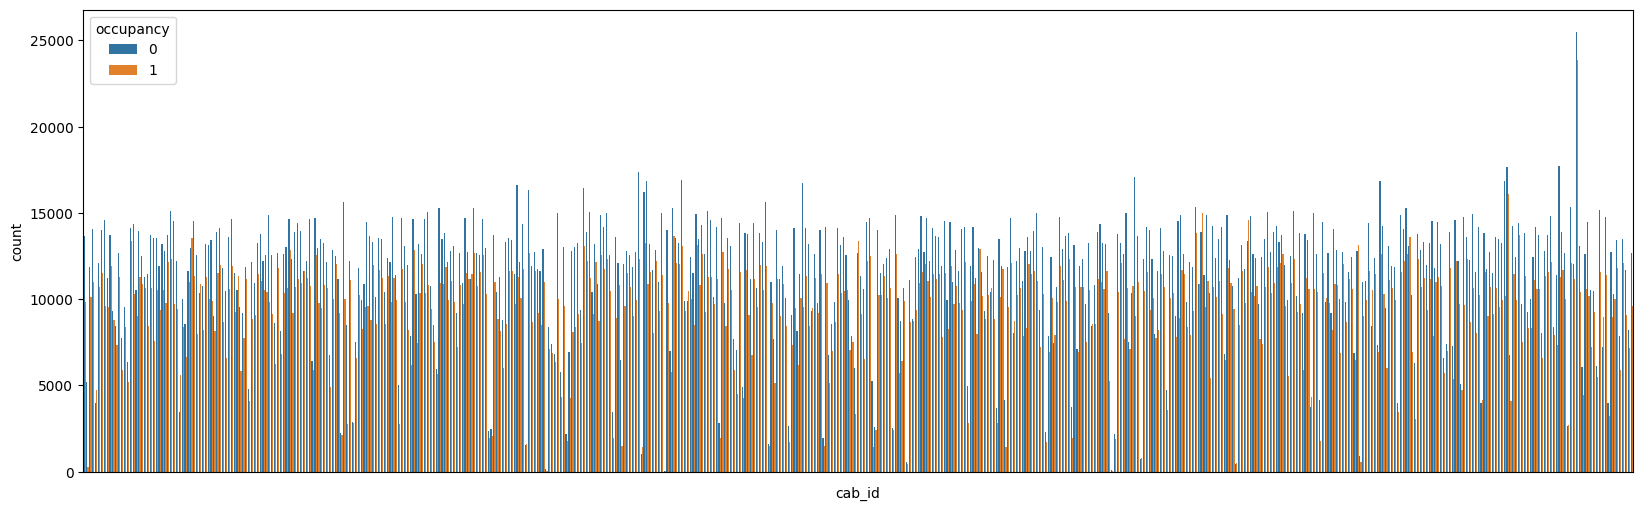

In [51]:
# num of samples 
plt.figure(figsize=(20,6))
ax = sns.countplot(x="cab_id", data=cabs_df, hue='occupancy')
ax.set(xticklabels=[]) 
ax.tick_params(bottom=False)